In [1]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from histo_utilities import create_TH1D, create_TH2D, std_color_list

# import CMS_lumi, tdrstyle
# tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 1
# CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.13/02


In [2]:
fpath = {}
tree = {}
process = {}
process_short = {}


#fpath['m50ct10000mm'] = '/Users/cmorgoth/llp_ntupler_gen_info.root'
fpath['qcd'] = '/Users/cmorgoth/qcd_llp_ntupler.root'
fpath['m50ct10000mm'] = '/Users/cmorgoth/llp_ntupler_mh125_mx50_pl10000_ALL.root'
process['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'
process_short['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'

print process
print process_short


for k,v in fpath.iteritems():
    print k, v
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["gLLP_decay_vertex_z"]
    print a[:-1][0]

{'glueBall': 'pp #rightarrow h*h* #rightarrow jj#nu#nu'}
{'glueBall': 'pp #rightarrow h*h* #rightarrow jj#nu#nu'}
m50ct10000mm /Users/cmorgoth/llp_ntupler_mh125_mx50_pl10000_ALL.root
[ 290.65445 -304.07755]
qcd /Users/cmorgoth/qcd_llp_ntupler.root
[-666. -666.]


In [3]:
#T = tree['glueBall']
T = tree['m50ct10000mm']
T_bkg = tree['qcd']

In [4]:
#get first jet pt per event
print T['jetPt']
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt']]
#print first_jet_pt

[array([32.053577], dtype=float32) array([], dtype=float32)
 array([], dtype=float32) ... array([45.861034], dtype=float32)
 array([24.10495], dtype=float32) array([], dtype=float32)]


In [5]:
x = np.arange(-5, 5, 1)
#print x
y = np.arange(-5, 5, 1)
xx, yy = np.meshgrid(x, y, sparse=True)
print xx
print yy

[[-5 -4 -3 -2 -1  0  1  2  3  4]]
[[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]]


In [6]:
#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z']]
#print max_jet_pt

In [7]:
#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt']:
    if len(x) == 0:
        break
    #print x
    first_jet_pt_arr.append(x[0])

In [8]:
MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

[[ 1.85741401 -3.00799656]
 [-4.         -2.        ]
 [-4.          0.        ]
 [-4.          2.        ]
 [-4.          4.        ]
 [-2.         -4.        ]
 [-2.20135641 -2.31564736]
 [-1.8622781   0.32907382]
 [-2.23181105  2.54141665]
 [-2.          4.        ]
 [ 0.         -4.        ]
 [ 0.         -2.        ]
 [ 0.          0.        ]
 [ 0.          2.        ]
 [ 0.          4.        ]
 [ 1.98246765 -3.10955763]
 [ 2.         -2.        ]
 [ 2.28290582  0.7347033 ]
 [ 2.          2.        ]
 [ 2.          4.        ]
 [ 4.         -4.        ]
 [ 4.         -2.        ]
 [ 4.          0.        ]
 [ 4.          2.        ]
 [ 4.          4.        ]]
2


Info in <TCanvas::Print>: pdf file ncsc_signal_vs_bkg.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ncsc_signal_vs_bkg.C has been generated
Info in <TCanvas::Print>: pdf file 2d_signal_event.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: 2d_signal_event.C has been generated


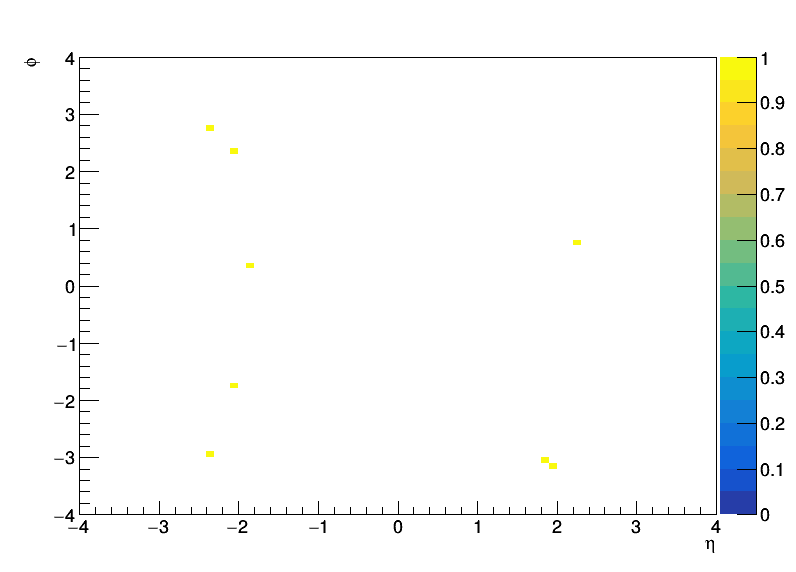

In [9]:
#Create Numpy Arrays for (['cscEta', 'cscPhi', 'cscX', 'cscY']) w
four_highest_jet_var = {}

#for v in ['jetPt', 'jetEta', 'jetPhi', 'jetE']:
#    tmp = []
#print T['gLLP_decay_vertex_z']
#print T['gLLP_decay_vertex_z'][:,0]

##ORIGINAL
sel_dis1 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 500 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1000, np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
sel_dis2 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,1]) > 500 , np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 1000, np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100)
sel_dis3 = np.sqrt(T['gLLP_decay_vertex_x'][:,0]*T['gLLP_decay_vertex_x'][:,0] + T['gLLP_decay_vertex_y'][:,0]*T['gLLP_decay_vertex_y'][:,0]) < 100
sel_dis4 = np.sqrt(T['gLLP_decay_vertex_x'][:,1]*T['gLLP_decay_vertex_x'][:,1] + T['gLLP_decay_vertex_y'][:,1]*T['gLLP_decay_vertex_y'][:,1]) < 100
sel_dis12 = np.logical_or(sel_dis1,sel_dis2)
sel_dis34 = np.logical_and(sel_dis3,sel_dis4)

#sel_prompt = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100 , np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
#sel_displaced =  np.logical_or(sel_dis1,sel_dis2)

#print T['jetPt'].shape
#sel_dis1 = [True if x.any > 50 else False for x in T['jetPt']]
#sel_dis2 = [True if x.any > 50 else False for x in T['jetPt']]
sel_prompt = [True if x.any > 50 else False for x in T_bkg['jetPt']]
#sel_displaced =  np.logical_and(sel_dis12,sel_dis34)
sel_displaced = sel_dis12

#print sel_displaced

csc_eta_dis = T['cscEta'][sel_displaced]
csc_phi_dis = T['cscPhi'][sel_displaced]
csc_x_dis = T['cscX'][sel_displaced]
csc_y_dis = T['cscY'][sel_displaced]
csc_z_dis = T['cscZ'][sel_displaced]
nCsc_dis = T['nCsc'][sel_displaced]

csc_eta_prompt = T_bkg['cscEta'][sel_prompt]
csc_phi_prompt = T_bkg['cscPhi'][sel_prompt]
csc_x_prompt = T_bkg['cscX'][sel_prompt]
csc_y_prompt = T_bkg['cscY'][sel_prompt]
csc_z_prompt = T_bkg['cscZ'][sel_prompt]
nCsc_prompt = T_bkg['nCsc'][sel_prompt]

#print nCsc_dis.ndim, nCsc_dis.shape, nCsc_dis.size
#print np.vstack((csc_eta_dis[0],csc_phi_dis[0])).T.ndim
evt_idx = 12
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['nCsc_dis'] = create_TH1D(nCsc_dis, axis_title=['nCsc_dis', 'Events'], name='nCsc_dis', binning=[250,0,500])
h['nCsc_dis'].SetLineColor(4)
h['nCsc_prompt'] = create_TH1D(nCsc_prompt, axis_title=['nCsc_prompt', 'Events'], name='nCsc_prompt', binning=[250,0,500])
h['nCsc_prompt'].SetLineColor(2)
c.SetLogy()
#h['llp_eta'].SetStats(0)
h['nCsc_dis'].Scale(1.0/h['nCsc_dis'].Integral())
h['nCsc_prompt'].Scale(1.0/h['nCsc_prompt'].Integral())
h['nCsc_dis'].SetLineWidth(2)
h['nCsc_prompt'].SetLineWidth(2)
h['nCsc_dis'].GetXaxis().SetRangeUser(0,200)
h['nCsc_prompt'].GetXaxis().SetRangeUser(0,200)
h['nCsc_dis'].SetLineWidth(2)
h['nCsc_prompt'].SetLineWidth(2)
h['nCsc_prompt'].SetStats(0)
h['nCsc_prompt'].SetTitle("")
h['nCsc_prompt'].SetXTitle("N_{csc}")
h['nCsc_prompt'].Draw('histo')
h['nCsc_dis'].Draw('histo+same')
h['nCsc_prompt'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_dis'], "Signal" , "L");
legend.AddEntry( h['nCsc_prompt'], "Bkg." , "L");
legend.Draw();

#c.Draw()
c.SaveAs("ncsc_signal_vs_bkg.pdf")
c.SaveAs("ncsc_signal_vs_bkg.C")

#print h['nCsc_prompt'].Integral(15,250)
#print h['nCsc_dis'].Integral(15,250)

c1 = rt.TCanvas('c1','c1', 800, 600)
h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])
#h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_dis[evt_idx],csc_phi_dis[evt_idx])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])
c1.SetLogy(0)
h['eta_phi_0'].SetStats(0)
c1.cd()
#h['eta_phi_0'].SetStats(0)
h['eta_phi_0'].Draw("colz")
c1.Draw()
c1.SaveAs("2d_signal_event.pdf")
c1.SaveAs("2d_signal_event.C")

test_dataset = np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T
#test_dataset = np.vstack((csc_eta_dis[evt_idx],csc_phi_dis[evt_idx])).T
#print test_dataset.ndim
#print len(csc_eta_prompt[evt_idx])
centroids_t,centroid_constituents_t = kmeans(test_dataset,25)
print centroids_t
print np.amax(centroid_constituents_t)
#print len(csc_eta_prompt[evt_idx])


    


In [10]:
n_min_prompt  = []
n_max_prompt  = []
n_hits_prompt = []

for eta,phi in zip(csc_eta_prompt,csc_phi_prompt):
    test_dataset = np.vstack((eta,phi)).T
    centroids,centroid_constituents = kmeans(test_dataset,25)
    #print len(eta), centroid_constituents
    nhits = 0
    #print '============================'
    for hits in centroid_constituents:
        nhits += hits
        #print hits
        
    #print 'hhits=>', nhits
    n_hits_prompt.append(nhits)
    n_max_prompt.append(np.amax(centroid_constituents))
    #print 'phi', phi
    

#for i,j,k in zip(n_hits_prompt,nCsc_prompt,n_max_prompt):
    #print i,j,k
#   print '->',i,j
    
    
n_max_dis = []
n_min_dis = []
centroids,centroid_constituents = kmeans(test_dataset,25)
for eta,phi in zip(csc_eta_dis,csc_phi_dis):
    test_dataset = np.vstack((eta,phi)).T
    centroids,centroid_constituents = kmeans(test_dataset,25)
    #n_min.append(np.min(centroid_constituents[np.nonzero(centroid_constituents)]))
    #n_max.append(np.max(centroid_constituents[np.nonzero(centroid_constituents)]))
    #print np.nonzero(centroid_constituents)[0], centroid_constituents[np.transpose(np.nonzero(centroid_constituents)[0])]
    #print 'eta', eta
    #print centroid_constituents
    #print centroid_constituents.ravel()[np.flatnonzero(centroid_constituents)]
    n_max_dis.append(np.amax(centroid_constituents))
    n_min_dis.append(np.amin(centroid_constituents))
    #print 'phi', phi



0.00663871418588
0.439253753981


Info in <TCanvas::Print>: pdf file muon_roi_trigger_bkg_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_vs_bkg.pdf has been created


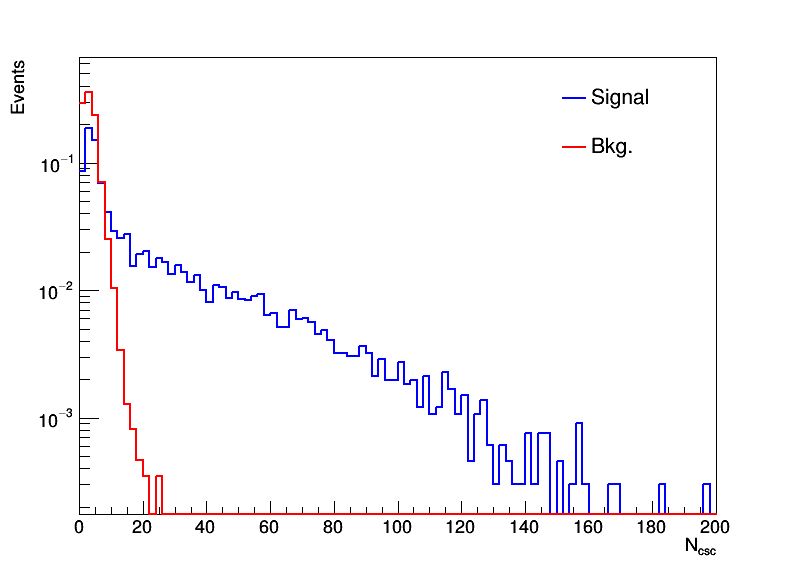

In [11]:
c2 = rt.TCanvas('c2','c2', 800, 600)
h['nmax_dis'] = create_TH1D(n_max_dis, axis_title=['nCsc_dis', 'Events'], name='nmax_dis', binning=[250,0,500])
h['nmax_dis'].SetLineColor(4)
h['nmax_prompt'] = create_TH1D(n_max_prompt, axis_title=['nmax_prompt', 'Events'], name='nmax_prompt', binning=[250,0,500])
h['nmax_prompt'].SetLineColor(2)
c2.SetLogy()
#h['llp_eta'].SetStats(0)
h['nmax_dis'].Scale(1.0/h['nmax_dis'].Integral())
h['nmax_prompt'].Scale(1.0/h['nmax_prompt'].Integral())
h['nCsc_dis'].SetLineColor(8)
h['nCsc_prompt'].SetLineColor(6)

#HISTO INFO
print h['nmax_prompt'].Integral(7,250)
print h['nmax_dis'].Integral(7,250)

#DRAW HISTOGRAMS
h['nmax_prompt'].GetXaxis().SetRangeUser(0,200)
h['nmax_prompt'].Draw('histo')
#h['nmax_dis'].Draw('histo+same')
#h['nCsc_dis'].Draw('histo+same')
h['nCsc_prompt'].Draw('histo+same')

c2.Draw()
c2.SaveAs("muon_roi_trigger_bkg_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(2)
h['nCsc_dis'].SetLineColor(6)
h['nmax_dis'].Draw('histo')
h['nCsc_dis'].Draw('histo+same')
c2.SaveAs("muon_roi_trigger_signal_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(4)
h['nmax_prompt'].SetLineColor(2)
h['nmax_dis'].SetLineWidth(2)
h['nmax_prompt'].SetLineWidth(2)
h['nmax_prompt'].SetStats(0)
h['nmax_prompt'].SetTitle("")
h['nmax_prompt'].SetXTitle("N_{csc}")

h['nmax_prompt'].Draw('histo')
h['nmax_dis'].Draw('histo+same')
h['nmax_prompt'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nmax_dis'], "Signal" , "L");
legend.AddEntry( h['nmax_prompt'], "Bkg." , "L");
legend.Draw();

c2.SaveAs("muon_roi_trigger_signal_vs_bkg.pdf")
